# Migration

For modifying orbital elements, REBOUNDx offers two implementations.  `modify_orbits_direct` directly calculates orbital elements and modifies those, while `modify_orbits_forces` applies forces that when orbit-averaged yield the desired behavior.  Let's set up a simple simulation of two planets on initially eccentric and inclined orbits:

In [1]:
import rebound
import reboundx
import numpy as np
sim = rebound.Simulation()
ainner = 1.
aouter = 10.
e0 = 0.1
inc0 = 0.1

sim.add(m=1.)
sim.add(m=1e-6,a=ainner,e=e0, inc=inc0)
sim.add(m=1e-6,a=aouter,e=e0, inc=inc0)
sim.move_to_com() # Moves to the center of momentum frame
ps = sim.particles

Now let's set up `reboundx` and add the `modify_orbits_forces` effect, which implements the migration using forces:

In [2]:
rebx = reboundx.Extras(sim)
mod_effect = rebx.add("modify_orbits_forces")

Both `modify_orbits_forces` and `modify_orbits_direct` exponentially alter the semimajor axis, on an e-folding timescale `tau_a`.  **If `tau_a` < 0, you get exponential damping, and for `tau_a` > 0, exponential growth, i.e.,**
\begin{equation}
a = a_0e^{t/\tau_a}
\end{equation}

In general, each body will have different damping timescales.  By default all particles have timescales of infinity, i.e., no effect.  The units of time are set by the units of time in your simulation.

Let's set a maximum time for our simulation, and give our two planets different (inward) migration timescales.  This can simply be done through:

In [3]:
tmax = 1.e3
ps[1].params["tau_a"] = -tmax/2.
ps[2].params["tau_a"] = -tmax   

Now we run the simulation like we would normally with REBOUND.  Here we store the semimajor axes at 1000 equally spaced intervals:

In [4]:
Nout = 1000
a1,a2 = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0.,tmax,Nout)
for i,time in enumerate(times):
    sim.integrate(time)
    a1[i] = ps[1].a
    a2[i] = ps[2].a

Now let's plot it on a linear-log scale to check whether we get the expected exponential behavior.  We'll also overplot the expected exponential decays for comparison.

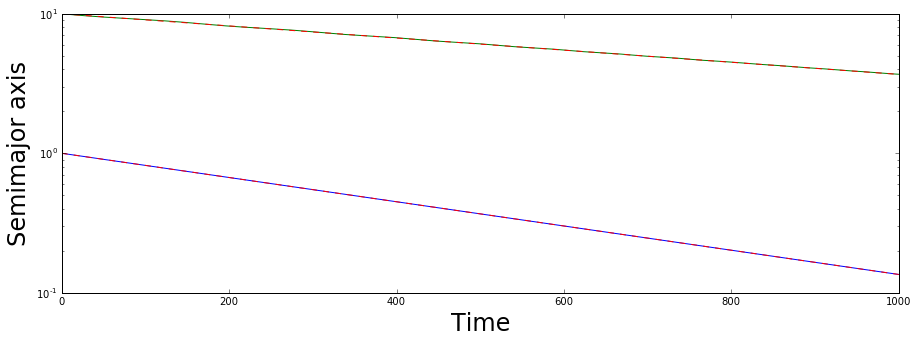

In [5]:
a1pred = [ainner*np.e**(t/ps[1].params["tau_a"]) for t in times]
a2pred = [aouter*np.e**(t/ps[2].params["tau_a"]) for t in times]

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
plt.plot(times,a1)
plt.plot(times,a2)
plt.plot(times,a1pred, 'r--')
plt.plot(times,a2pred, 'r--')
plt.axes().set_xlabel("Time", fontsize=24)
plt.axes().set_ylabel("Semimajor axis", fontsize=24)

**Coordinate Systems**

Everything in REBOUND by default uses Jacobi coordinates.  To change the coordinate system, see the bottom of [EccAndIncDamping.ipynb](EccAndIncDamping.ipynb)